# Соревнование от AI VK по предсказанию явного фидбэка (лайков/дизлайков) пользователей VK Клипов.

Данные пользователей за 6 недель, упорядоченные по времени (первые строки самые давние).

**Столбцы файла `train_interactions.parquet`:**

- `user_id` - уникальный идентификатор пользователя;
- `item_id` - уникальный идентификатор клипа;
- `timespent` - время, которое пользователь провел на клипе;
- `like` - лайкнул ли пользователь клип;
- `dislike` - дизлайкнул ли пользователь клип;
- `share` - поделился ли пользователь клипом;
- `bookmarks` - поместил ли пользователь клип в закладки.

**Файл `users_meta.parquet` содержит данные о пользователе:**

- `user_id` - уникальный идентификатор пользователя;
- `gender` - пол пользователя;
- `age` - возраст пользователя.

**Файл `items_meta.parquet` содержит информацию о клипе:**

- `item_id` - уникальный идентификатор клипа;
- `source_id` - уникальный идентификатор автора клипа;
- `duration` - длительность клипа в секундах;
- `embeddings` - нейросетевые эмбеддинги содержимого клипа (видеоряд, звук и тд.).

**Файл `test_pairs.csv` содержит пары юзеров/клипов, для которых нужно сделать предсказание. Пары собраны за седьмую неделю (сразу после тренировочных).**

**Метрика соревнования: ROC AUC, но на трех метках (like = 1, dislike = -1, ignore = 0)**

$$
\text{ROC AUC} = \frac{1}{|U|}\sum_{u\in U}\frac{\sum_{i\in I_{u}}\sum_{j\in I_{u}}[r_{ui}\lt r_{uj}][\hat{r}_{ui}\lesssim \hat{r}_{uj}]}{\sum_{i\in I_{u}}\sum_{j\in I_{u}}[r_{ui}\lt r_{uj}]}
$$

$$
[\hat{r}_{ui}\lesssim \hat{r}_{uj}] = \begin{cases}0 & \text{if $\hat{r}_{ui}\gt  \hat{r}_{uj}$}\\0.5 & \text{if $\hat{r}_{ui}=  \hat{r}_{uj}$}\\1 & \text{if $\hat{r}_{ui}\lt   \hat{r}_{uj}$}\end{cases}
$$

$$
[r_{ui}\lt r_{uj}] = \begin{cases}0 & \text{if $r_{ui}\ge r_{uj}$}\\1 & \text{if $r_{ui}\lt r_{uj}$}\end{cases}
$$

$r_{ui} \to  \text{Истинная реакция пользователя u на айтем i}$

$\hat{r}_{ui} \to  \text{Предсказанный скор пользователя u на айтем i}$

$U \to  \text{Множество тестовых пользователей}$

$I_{u} \to \text{Множество тестовых айтемов пользователя u}$

In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install implicit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 52.7 MB/s eta 0:00:0000:0100:01


In [4]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 2.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=447717 sha256=868d9e45ba4c1c6480a24211a6233388b79ebcb2828f0f5436118f925abc3304
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [5]:
from scipy.sparse import csr_matrix
import polars as pl
import implicit
from lightfm import LightFM

In [29]:
train = pl.scan_parquet("/kaggle/input/vk-recsys-data/train_interactions.parquet")

items_meta = pl.read_parquet("/kaggle/input/vk-recsys-data/items_meta.parquet.parquet")
users_meta = pl.read_parquet("/kaggle/input/vk-recsys-data/users_meta.parquet.parquet")

n_items = items_meta["item_id"].max() + 1
n_users = users_meta["user_id"].max() + 1

train = train.filter((pl.col("like") + pl.col("dislike")) >= 1)
train = train.with_columns(weight=pl.col("like") - pl.col("dislike"))

train = train.collect()
train

user_id,item_id,timespent,like,dislike,share,bookmarks,weight
u32,u32,u8,u8,u8,u8,u8,u8
3163,147750,21,1,0,0,0,1
113832,306166,12,1,0,0,0,1
124909,128209,27,1,0,0,0,1
183076,91080,14,1,0,0,0,1
156215,289701,6,1,0,0,0,1
…,…,…,…,…,…,…,…
153247,209536,10,1,0,0,0,1
21973,291285,255,1,0,0,0,1
129733,183808,3,1,0,0,0,1


In [43]:
train.collect_schema()

Schema([('user_id', UInt32),
        ('item_id', UInt32),
        ('timespent', UInt8),
        ('like', UInt8),
        ('dislike', UInt8),
        ('share', UInt8),
        ('bookmarks', UInt8)])

In [30]:
train = train.join(users_meta, on="user_id", how="left").join(items_meta, on="item_id", how="left") # polaris df
train.head()

user_id,item_id,timespent,like,dislike,share,bookmarks,weight,gender,age,source_id,duration,embeddings
u32,u32,u8,u8,u8,u8,u8,u8,u8,u8,u32,u8,"array[f32, 32]"
3163,147750,21,1,0,0,0,1,1,33,13157,15,"[-0.145122, -0.069121, … 0.00912]"
113832,306166,12,1,0,0,0,1,2,23,12618,6,"[-0.063024, -0.073985, … 0.155499]"
124909,128209,27,1,0,0,0,1,2,26,6339,22,"[0.550597, 0.032275, … -0.027312]"
183076,91080,14,1,0,0,0,1,2,20,2911,12,"[-0.184676, 0.063867, … -0.065469]"
156215,289701,6,1,0,0,0,1,1,24,1459,5,"[-0.416369, -0.091435, … -0.099472]"


In [31]:
train = train.with_columns((train["timespent"] + train["weight"] + \
                            train["share"] + train["bookmarks"] + \
                            train["gender"] * 0.5 + train["age"] * 0.2 + \
                            train["duration"] * 0.01).alias("weight_2"))

train.head()

user_id,item_id,timespent,like,dislike,share,bookmarks,weight,gender,age,source_id,duration,embeddings,weight_2
u32,u32,u8,u8,u8,u8,u8,u8,u8,u8,u32,u8,"array[f32, 32]",f64
3163,147750,21,1,0,0,0,1,1,33,13157,15,"[-0.145122, -0.069121, … 0.00912]",29.25
113832,306166,12,1,0,0,0,1,2,23,12618,6,"[-0.063024, -0.073985, … 0.155499]",18.66
124909,128209,27,1,0,0,0,1,2,26,6339,22,"[0.550597, 0.032275, … -0.027312]",34.42
183076,91080,14,1,0,0,0,1,2,20,2911,12,"[-0.184676, 0.063867, … -0.065469]",20.12
156215,289701,6,1,0,0,0,1,1,24,1459,5,"[-0.416369, -0.091435, … -0.099472]",12.35


In [40]:
from lightfm.data import Dataset

# Создание объекта Dataset
dataset = Dataset()

# Все уникальные user_id из мета-данных
all_user_ids = users_meta['user_id'].unique()

# Все уникальные item_id из мета-данных
all_item_ids = items_meta['item_id'].unique()

# Подготовка данных для модели, включая все пользователей и товары
dataset.fit(all_user_ids, all_item_ids)

In [41]:
# Строим набор взаимодействий (user_id, item_id, вес)
(interactions, weights) = dataset.build_interactions(
    [(row['user_id'], row['item_id'], row['weight_2']) for row in train_data.to_dicts()]
)

In [42]:
# Создание модели
model = LightFM(
    no_components=32,  # Число латентных факторов
    loss="warp",       # Loss function (warp, bpr, logistic)
    learning_rate=0.05, 
    item_alpha=0.001   # Регуляризация
)

# Обучение
model.fit(interactions, sample_weight=weights, epochs=10, num_threads=4)


In [43]:
test_pairs = pl.read_csv('/kaggle/input/vk-recsys-data/test_pairs.csv.csv')
test_pairs

user_id,item_id
i64,i64
1,7363
1,73770
1,75700
1,81204
1,110249
…,…
183403,235097
183403,267411
183403,273646


In [45]:
import polars as pl
import numpy as np
from lightfm import LightFM

test_pairs = pl.read_csv('/kaggle/input/vk-recsys-data/test_pairs.csv.csv')
test_pairs

# Преобразование данных в numpy массивы
user_ids = test_pairs['user_id'].to_numpy()
item_ids = test_pairs['item_id'].to_numpy()

# Получение предсказаний для каждой пары
predictions = model.predict(
    user_ids,  # Индексы пользователей (в виде массива NumPy)
    item_ids   # Индексы товаров (в виде массива NumPy)
)

# Добавление предсказаний в DataFrame
test_pairs = test_pairs.with_columns(
    pl.Series("predict", predictions)
)

# Сохранение результатов в CSV
test_pairs[['user_id', 'item_id', 'predict']].write_csv('submission_lightfm.csv')


## Бейз

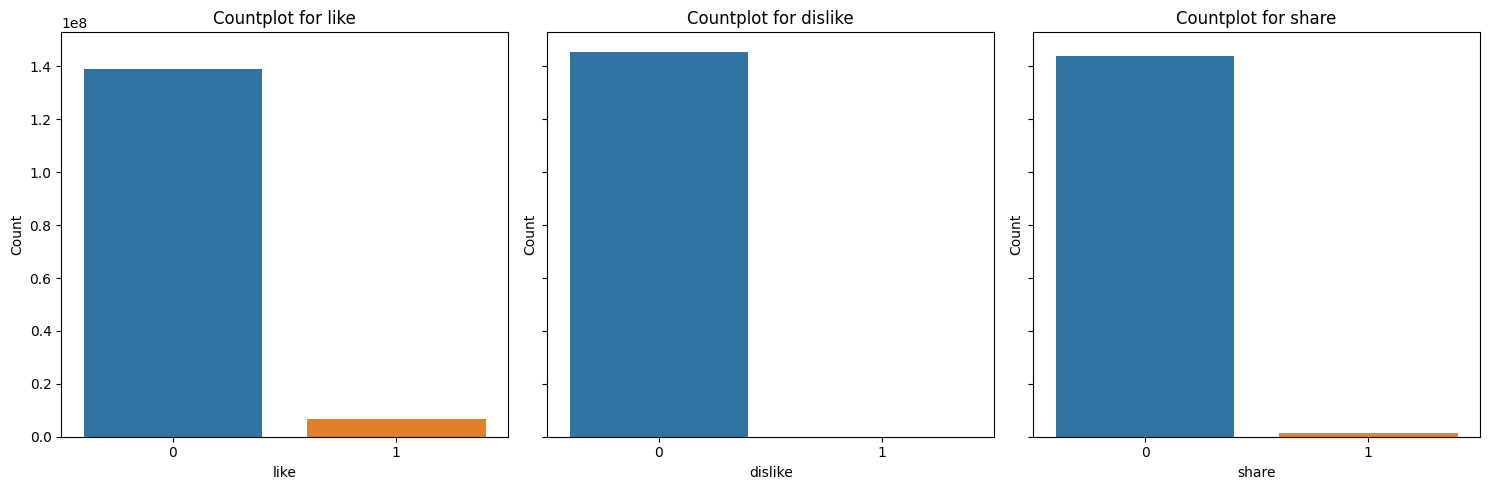

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразуем Polars DataFrame в Pandas DataFrame
train_pd = train.to_pandas()

# Укажите названия столбцов для визуализации
columns = ["like", "dislike", "share"]  # Замените на реальные названия столбцов

# Создаем субплоты: 1 строка, количество столбцов равное числу графиков
fig, axes = plt.subplots(1, len(columns), figsize=(15, 5), sharey=True)

# Построение countplot для каждого столбца
for ax, col in zip(axes, columns):
    sns.countplot(data=train_pd, x=col, ax=ax)
    ax.set_title(f"Countplot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

# Показываем графики
plt.tight_layout()
plt.show()


In [31]:
train['dislike'].value_counts()

dislike,count
u8,u32
1,57262
0,145610020


In [32]:
train['bookmarks'].value_counts()

bookmarks,count
u8,u32
1,143603
0,145523679


In [45]:
train = train.filter((pl.col("like") + pl.col("dislike")) >= 1)
train

user_id,item_id,timespent,like,dislike,share,bookmarks
u32,u32,u8,u8,u8,u8,u8
3163,147750,21,1,0,0,0
113832,306166,12,1,0,0,0
124909,128209,27,1,0,0,0
183076,91080,14,1,0,0,0
156215,289701,6,1,0,0,0
…,…,…,…,…,…,…
153247,209536,10,1,0,0,0
21973,291285,255,1,0,0,0
129733,183808,3,1,0,0,0


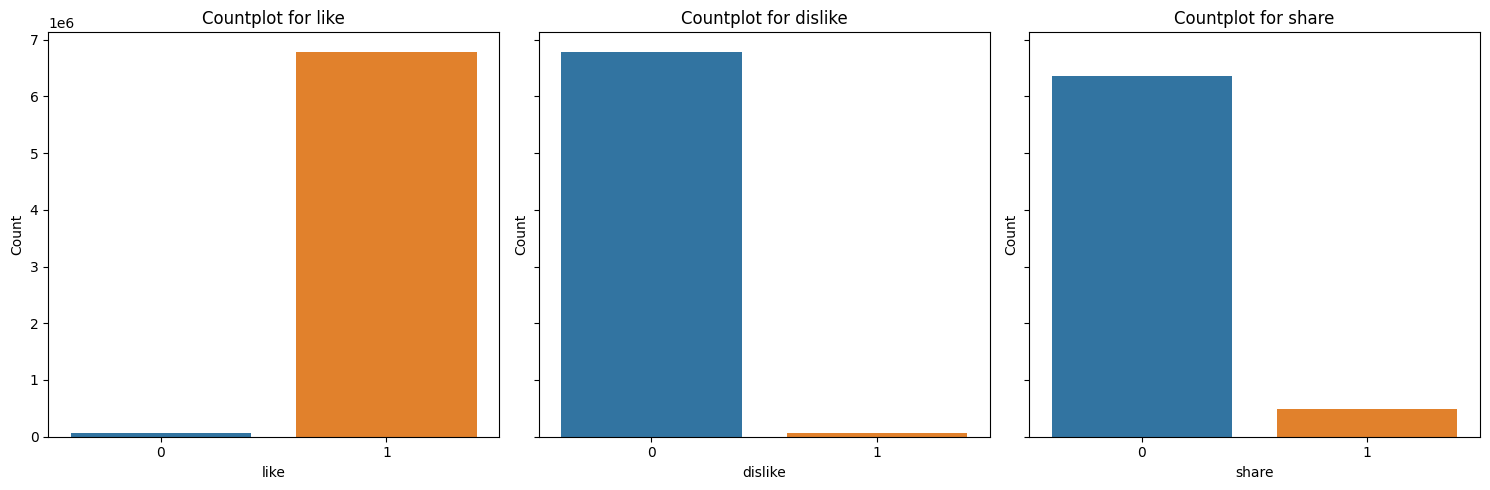

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Преобразуем Polars DataFrame в Pandas DataFrame
train_pd = train.to_pandas()

# Укажите названия столбцов для визуализации
columns = ["like", "dislike", "share"]  # Замените на реальные названия столбцов

# Создаем субплоты: 1 строка, количество столбцов равное числу графиков
fig, axes = plt.subplots(1, len(columns), figsize=(15, 5), sharey=True)

# Построение countplot для каждого столбца
for ax, col in zip(axes, columns):
    sns.countplot(data=train_pd, x=col, ax=ax)
    ax.set_title(f"Countplot for {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

# Показываем графики
plt.tight_layout()
plt.show()

In [47]:
train = train.with_columns(weight=pl.col("like") - pl.col("dislike"))
train.head()

user_id,item_id,timespent,like,dislike,share,bookmarks,weight
u32,u32,u8,u8,u8,u8,u8,u8
3163,147750,21,1,0,0,0,1
113832,306166,12,1,0,0,0,1
124909,128209,27,1,0,0,0,1
183076,91080,14,1,0,0,0,1
156215,289701,6,1,0,0,0,1


In [49]:
train.shape

(6845529, 8)

In [48]:
n_users = train["user_id"].n_unique()
n_items = train["item_id"].n_unique()

print(n_users)
print(n_items)

150273
268904


In [50]:
train = train.select("user_id", "item_id", "weight")

In [53]:
items_meta = pl.read_parquet("/kaggle/input/vk-recsys-data/items_meta.parquet.parquet")
users_meta = pl.read_parquet("/kaggle/input/vk-recsys-data/users_meta.parquet.parquet")
n_items = items_meta["item_id"].max() + 1
n_users = users_meta["user_id"].max() + 1

In [54]:
sparse_matrix = csr_matrix(
    (train["weight"].to_numpy(), 
     (train["user_id"].to_numpy(), train["item_id"].to_numpy())),
    shape=(n_users, n_items)
)

print(sparse_matrix)

<Compressed Sparse Row sparse matrix of dtype 'uint8'
	with 6845529 stored elements and shape (183404, 337727)>
  Coords	Values
  (0, 9836)	1
  (0, 39269)	1
  (0, 41951)	1
  (0, 67567)	1
  (0, 67584)	1
  (0, 108059)	1
  (0, 120225)	1
  (0, 159795)	1
  (0, 165053)	1
  (0, 168275)	1
  (0, 195334)	1
  (0, 200400)	1
  (0, 201247)	1
  (0, 216603)	1
  (0, 223492)	1
  (0, 233565)	1
  (0, 233648)	1
  (0, 260752)	1
  (0, 261792)	1
  (0, 268519)	1
  (0, 276888)	1
  (0, 292932)	1
  (0, 305964)	1
  (0, 333336)	1
  (0, 336086)	1
  :	:
  (183402, 216773)	1
  (183402, 287800)	1
  (183402, 295606)	1
  (183402, 328818)	1
  (183403, 28)	1
  (183403, 25908)	1
  (183403, 69119)	1
  (183403, 72347)	1
  (183403, 78838)	1
  (183403, 95722)	1
  (183403, 121707)	1
  (183403, 126176)	1
  (183403, 186424)	1
  (183403, 193709)	1
  (183403, 205211)	1
  (183403, 207336)	1
  (183403, 207390)	1
  (183403, 221273)	1
  (183403, 239050)	1
  (183403, 241255)	1
  (183403, 252086)	1
  (183403, 273017)	1
  (183403, 299644)	

In [56]:
model = implicit.als.AlternatingLeastSquares(factors=16, 
                                             iterations=10, 
                                             regularization=1, 
                                             alpha=100,
                                             calculate_training_loss=True)
model.fit(sparse_matrix)

  0%|          | 0/10 [00:00<?, ?it/s]

In [57]:
test_pairs = pl.read_csv('/kaggle/input/vk-recsys-data/test_pairs.csv.csv')
test_pairs

user_id,item_id
i64,i64
1,7363
1,73770
1,75700
1,81204
1,110249
…,…
183403,235097
183403,267411
183403,273646


In [58]:
als_predict = (model.user_factors[test_pairs['user_id']] * 
               model.item_factors[test_pairs['item_id']]).sum(axis=1)

In [59]:
test_pairs.with_columns(predict=als_predict).write_csv('submission_base.csv')

## Улучшения

In [65]:
# Фильтрация и взвешивание
train = train.filter((pl.col("like") + pl.col("dislike")) >= 1)
train = train.with_columns(weight=pl.col("like") - pl.col("dislike"))

# Присоединение метаданных
train = train.join(users_meta, on="user_id", how="left").join(items_meta, on="item_id", how="left")

train

user_id,item_id,timespent,like,dislike,share,bookmarks,weight,gender,age,source_id,duration,embeddings
u32,u32,u8,u8,u8,u8,u8,u8,u8,u8,u32,u8,"array[f32, 32]"
3163,147750,21,1,0,0,0,1,1,33,13157,15,"[-0.145122, -0.069121, … 0.00912]"
113832,306166,12,1,0,0,0,1,2,23,12618,6,"[-0.063024, -0.073985, … 0.155499]"
124909,128209,27,1,0,0,0,1,2,26,6339,22,"[0.550597, 0.032275, … -0.027312]"
183076,91080,14,1,0,0,0,1,2,20,2911,12,"[-0.184676, 0.063867, … -0.065469]"
156215,289701,6,1,0,0,0,1,1,24,1459,5,"[-0.416369, -0.091435, … -0.099472]"
…,…,…,…,…,…,…,…,…,…,…,…,…
153247,209536,10,1,0,0,0,1,2,25,1377,6,"[-0.155724, -0.246018, … 0.129665]"
21973,291285,255,1,0,0,0,1,1,29,7233,45,"[0.412685, -0.148856, … -0.021627]"
129733,183808,3,1,0,0,0,1,2,21,18732,8,"[0.027356, -0.1183, … -0.055097]"


In [66]:
# Создание разреженной матрицы
train_matrix = csr_matrix((train["weight"], 
                           (train["user_id"].to_numpy(), 
                            train["item_id"].to_numpy())), 
                          shape=(n_users, n_items))

train_matrix

<Compressed Sparse Row sparse matrix of dtype 'uint8'
	with 6845529 stored elements and shape (183404, 337727)>

In [ ]:
# Создание разреженной матрицы
train_matrix = csr_matrix((train["weight"], 
                           (train["user_id"].to_numpy(), 
                            train["item_id"].to_numpy())), 
                          shape=(n_users, n_items))

# Обучение ALS
model = implicit.als.AlternatingLeastSquares(factors=32, 
                                             iterations=15, 
                                             regularization=0.1, 
                                             alpha=500)
model.fit(train_matrix)

# Предсказания
als_predict = (model.user_factors[test_pairs['user_id']] * 
               model.item_factors[test_pairs['item_id']]).sum(axis=1)

In [62]:
# Сохранение результатов
test_pairs = test_pairs.with_columns(predict=als_predict)
test_pairs.write_csv('submission_w_new_features.csv')

# Какая-то очередная проба (17/11)

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from scipy.sparse import csr_matrix
import polars as pl
import implicit
from lightfm import LightFM

In [ ]:
train = pl.scan_parquet("/kaggle/input/vk-recsys-data/train_interactions.parquet")

items_meta = pl.read_parquet("/kaggle/input/vk-recsys-data/items_meta.parquet.parquet")
users_meta = pl.read_parquet("/kaggle/input/vk-recsys-data/users_meta.parquet.parquet")

# все пользователи и видосы
n_items = items_meta["item_id"].max() + 1
n_users = users_meta["user_id"].max() + 1

# train = train.filter((pl.col("like") + pl.col("dislike")) >= 1)
# train = train.with_columns(weight=pl.col("like") - pl.col("dislike"))


# Загружаем данные лениво (если они еще не ленивы)
train_lazy = train.lazy()
users_meta_lazy = users_meta.lazy()
items_meta_lazy = items_meta.lazy()

# Применяем операции: кастинг типов и создание новой колонки 'weight'
train_lazy = (
    train_lazy
    .with_columns([
        pl.col("like").cast(pl.Int16),
        pl.col("dislike").cast(pl.Int16),
        pl.col("share").cast(pl.Int8),
        pl.col("bookmarks").cast(pl.Int8)
    ])
    .join(users_meta_lazy, on="user_id", how="left")
    .join(items_meta_lazy, on="item_id", how="left")
    .with_columns(weight=(
        (pl.col("like") - pl.col("dislike")) * 2 +  # Знаковое значение
        (pl.col("timespent") / pl.col("duration")) * 1.5 +  # Дробное значение
        pl.col("share") * 1 +
        pl.col("bookmarks") * 1
        # pl.col("gender") * 0.5 + pl.col("age") * 0.2  # Можно добавить эти признаки позже
        )
    )
)

# Выполнение запроса и преобразование обратно в DataFrame
train = train_lazy.collect()
train

In [46]:
print(len(np.unique(user_ids)), n_users)
print(len(np.unique(item_ids)), n_items)

183404 183404
337727 337727


In [ ]:
train = train.join(users_meta, on="user_id", how="left").join(items_meta, on="item_id", how="left") # polaris df

In [ ]:
train = train.with_columns(
    pl.col("like").cast(pl.Int16),
    pl.col("dislike").cast(pl.Int16),
    pl.col("timespent").cast(pl.Float32),
    pl.col("duration").cast(pl.Float32)
)


In [ ]:
# train = train.with_columns((train["timespent"] + \
#                             train["weight"] + train["share"] + train["bookmarks"] + \
#                             train["gender"] * 0.5 + train["age"] * 0.2 + train["duration"] * 0.01).alias("weight_2"))

train = train.with_columns((
        (pl.col("like") - pl.col("dislike")) * 2 +  # Знаковое значение
        (pl.col("timespent") / pl.col("duration")) * 1.5 +  # Дробное значение
        pl.col("share") * 1 +
        pl.col("bookmarks") * 1
#         tpl.col("gender") * 0.5 + pl.col("age") * 0.2
    ).alias("weight")
)

train

In [ ]:
# Отделяем последнюю неделю для валидации
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

print(train_data.shape)
print(val_data.shape)

In [ ]:
train_data_sparse_matrix = csr_matrix((train_data["weight"],
                                (train_data["user_id"].to_numpy(), 
                                train_data["item_id"].to_numpy())),
                                shape=(n_users, n_items))

train_data_sparse_matrix

In [8]:
model = implicit.als.AlternatingLeastSquares(
    factors=128,
    iterations=20,
    regularization=0.1,
    alpha=10,
    calculate_training_loss=True
)

model.fit(train_data_sparse_matrix)

,user_id,item_id,timespent,like,dislike,share,bookmarks,weight,gender,age,source_id,duration,embeddings
0,3163,147750,21,1,0,0,0,1,1,33,13157,15,"[-0.14512211, -0.06912128, 0.15605307, 0.11876..."
1,113832,306166,12,1,0,0,0,1,2,23,12618,6,"[-0.063024335, -0.07398529, -0.43315902, 0.090..."
2,124909,128209,27,1,0,0,0,1,2,26,6339,22,"[0.55059695, 0.03227464, 0.08555149, 0.2478415..."
3,183076,91080,14,1,0,0,0,1,2,20,2911,12,"[-0.18467589, 0.063866764, 0.02112074, -0.2380..."
4,156215,289701,6,1,0,0,0,1,1,24,1459,5,"[-0.41636884, -0.09143543, -0.26345775, 0.2152..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6845524,153247,209536,10,1,0,0,0,1,2,25,1377,6,"[-0.15572368, -0.24601802, -0.10183552, 0.1211..."
6845525,21973,291285,255,1,0,0,0,1,1,29,7233,45,"[0.41268545, -0.14885588, 0.03699824, 0.134176..."
6845526,129733,183808,3,1,0,0,0,1,2,21,18732,8,"[0.027356215, -0.11830016, -0.08800258, 0.0573..."
6845527,81472,274701,31,1,0,0,0,1,2,46,4385,38,"[0.196437, -0.048126496, -0.1849333, -0.173415..."


In [9]:
als_predict = (model.user_factors[test_pairs['user_id']] * 
               model.item_factors[test_pairs['item_id']]).sum(axis=1)

test_pairs.with_columns(predict=als_predict).write_csv('submission_v3.csv')

Schema([('user_id', UInt32),
        ('item_id', UInt32),
        ('timespent', UInt8),
        ('like', UInt8),
        ('dislike', UInt8),
        ('share', UInt8),
        ('bookmarks', UInt8),
        ('weight', UInt8),
        ('gender', UInt8),
        ('age', UInt8),
        ('source_id', UInt32),
        ('duration', UInt8),
        ('embeddings', Array(Float32, shape=(32,)))])

In [10]:
train = train.with_columns(
    pl.col("like").cast(pl.Int16),
    pl.col("dislike").cast(pl.Int16),
    pl.col("timespent").cast(pl.Float32),
    pl.col("duration").cast(pl.Float32)
)


In [11]:
train.collect_schema()

Schema([('user_id', UInt32),
        ('item_id', UInt32),
        ('timespent', Float32),
        ('like', Int16),
        ('dislike', Int16),
        ('share', UInt8),
        ('bookmarks', UInt8),
        ('weight', UInt8),
        ('gender', UInt8),
        ('age', UInt8),
        ('source_id', UInt32),
        ('duration', Float32),
        ('embeddings', Array(Float32, shape=(32,)))])

In [13]:
train

user_id,item_id,timespent,like,dislike,share,bookmarks,weight,gender,age,source_id,duration,embeddings,weight_2
u32,u32,f32,i16,i16,u8,u8,u8,u8,u8,u32,f32,"array[f32, 32]",f32
3163,147750,21.0,1,0,0,0,1,1,33,13157,15.0,"[-0.145122, -0.069121, … 0.00912]",4.1
113832,306166,12.0,1,0,0,0,1,2,23,12618,6.0,"[-0.063024, -0.073985, … 0.155499]",5.0
124909,128209,27.0,1,0,0,0,1,2,26,6339,22.0,"[0.550597, 0.032275, … -0.027312]",3.840909
183076,91080,14.0,1,0,0,0,1,2,20,2911,12.0,"[-0.184676, 0.063867, … -0.065469]",3.75
156215,289701,6.0,1,0,0,0,1,1,24,1459,5.0,"[-0.416369, -0.091435, … -0.099472]",3.8
…,…,…,…,…,…,…,…,…,…,…,…,…,…
153247,209536,10.0,1,0,0,0,1,2,25,1377,6.0,"[-0.155724, -0.246018, … 0.129665]",4.5
21973,291285,255.0,1,0,0,0,1,1,29,7233,45.0,"[0.412685, -0.148856, … -0.021627]",10.5
129733,183808,3.0,1,0,0,0,1,2,21,18732,8.0,"[0.027356, -0.1183, … -0.055097]",2.5625


In [15]:
train_pd_joined = train.to_pandas()
print(train_pd_joined['weight_2'].min(), train_pd_joined['weight_2'].max())

-1.9916667 80.5


In [16]:
# train = train.with_columns((train["timespent"] + \
#                             train["weight"] + train["share"] + train["bookmarks"] + \
#                             train["gender"] * 0.5 + train["age"] * 0.2 + train["duration"] * 0.01).alias("weight_2"))

train = train.with_columns((
        (pl.col("like") - pl.col("dislike")) * 2 +  # Знаковое значение
        (pl.col("timespent") / pl.col("duration")) * 1.5 +  # Дробное значение
        pl.col("share") * 1 +
        pl.col("bookmarks") * 1
#         tpl.col("gender") * 0.5 + pl.col("age") * 0.2
    ).alias("weight_2")
)

In [18]:
# Отделяем последнюю неделю для валидации
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

print(train_data.shape)
print(val_data.shape)

(5476423, 14)
(1369106, 14)


In [20]:
n_items = items_meta["item_id"].max() + 1
n_users = users_meta["user_id"].max() + 1

train_sparse = coo_matrix(
    (train_data['weight_2'], 
     (train_data['user_id'], train_data['item_id'])),
    shape=(n_users, n_items)
)


In [21]:
model = implicit.als.AlternatingLeastSquares(
    factors=128,
    iterations=20,
    regularization=0.1,
    alpha=10,
    calculate_training_loss=True
)

model.fit(train_sparse)

/opt/conda/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/opt/conda/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.3357980251312256 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
user_factors = model.user_factors
item_factors = model.item_factors

In [28]:
user_factors.shape, item_factors.shape

((183404, 128), (337727, 128))

In [37]:
train_data['item_id'].unique()

item_id
u32
0
1
2
3
4
…
337717
337718
337719


In [35]:
# Присоединение user_factors
user_latent_df = pl.DataFrame(user_factors, schema=[f"user_factor_{i}" for i in range(user_factors.shape[1])])
user_latent_df = user_latent_df.with_columns(pl.Series("user_id", train_data["user_id"].unique()))

# Присоединение item_factors
item_latent_df = pl.DataFrame(item_factors, schema=[f"item_factor_{i}" for i in range(item_factors.shape[1])])
item_latent_df = item_latent_df.with_columns(pl.Series("item_id", train_data["item_id"].unique()))

# Объединяем с train_data по user_id и item_id
train_data = train_data.join(user_latent_df, on="user_id", how="left")
train_data = train_data.join(item_latent_df, on="item_id", how="left")

ShapeError: unable to add a column of length 145847 to a DataFrame of height 183404

In [25]:
# Присоединяем метаданные к взаимодействиям
train_data = train_data.join(user_latent_df, on='user_id', how='left')
train_data = train_data.join(item_latent_df, on='item_id', how='left')

# Признаки и целевая переменная
features = [col for col in train_data.columns if col not in ['user_id', 'item_id', 'weight_2']]
X_train = train_data[features]
y_train = train_data['weight_2']


TypeError: expected `other` join table to be a DataFrame, got 'DataFrame'

In [ ]:
val_data = val_data.merge(user_latent_df, on='user_id', how='left')
val_data = val_data.merge(item_latent_df, on='item_id', how='left')

X_val = val_data[features]
y_val = val_data['weight']


In [ ]:
from lightgbm import LGBMClassifier

model_ml = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=7)
model_ml.fit(X_train, y_train)

In [ ]:
y_pred = model_ml.predict_proba(X_val)[:, 1]  # Вероятность положительного класса
roc_auc = roc_auc_score(y_val > 0, y_pred)  # ROC AUC
print(f"ROC AUC: {roc_auc:.4f}")